# ChatOllama

[Ollama](https://ollama.ai/) allows you to run open-source large language models, such as LLaMA2, locally.

Ollama bundles model weights, configuration, and data into a single package, defined by a Modelfile. 

It optimizes setup and configuration details, including GPU usage.

For a complete list of supported models and model variants, see the [Ollama model library](https://ollama.ai/library).

## Setup

First, follow [these instructions](https://github.com/jmorganca/ollama) to set up and run a local Ollama instance:

* [Download](https://ollama.ai/download)
* Fetch a model via `ollama pull <model family>`
* e.g., for `Llama-7b`: `ollama pull llama2`
* This will download the most basic version of the model (e.g., minimum # parameters and 4-bit quantization)
* On Mac, it will download to:

`~/.ollama/models/manifests/registry.ollama.ai/library/<model family>/latest`

* And we can specify a particular version, e.g., for `ollama pull vicuna:13b-v1.5-16k-q4_0`
* The file is here with the model version in place of `latest`

`~/.ollama/models/manifests/registry.ollama.ai/library/vicuna/13b-v1.5-16k-q4_0`

You can easily access models in a few ways:

1/ if the app is running:

* All of your local models are automatically served on `localhost:11434`
* Select your model when setting `llm = Ollama(..., model="<model family>:<version>")`
* If you set `llm = Ollama(..., model="<model family")` withoout a version it will simply look for `latest`

2/ if building from source or just running the binary: 

* Then you must run `ollama serve`
* All of your local models are automatically served on `localhost:11434`
* Then, select as shown above


## Usage

You can see a full list of supported parameters on the [API reference page](https://api.python.langchain.com/en/latest/llms/langchain.llms.ollama.Ollama.html).

If you are using a LLaMA `chat` model (e.g., `ollama pull llama2:7b-chat`) then you can use the `ChatOllama` interface.

This includes [special tokens](https://huggingface.co/blog/llama2#how-to-prompt-llama-2) for system message and user input.

In [1]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

chat_model = ChatOllama(
    model="llama2:7b-chat",
)

Optionally, pass `StreamingStdOutCallbackHandler` to stream tokens:

```
chat_model = ChatOllama(
    model="llama2:7b-chat",
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)
```

In [2]:
from langchain.schema import HumanMessage

messages = [HumanMessage(content="Tell me about the history of AI")]
chat_model(messages)

AIMessage(content='\nArtificial intelligence (AI) has a rich and diverse history that spans several decades. Here is a brief overview of the major milestones and events in the development of AI:\n\n1. 1950s: The Dartmouth Conference: The field of AI was officially launched at a conference held at Dartmouth College in 1956. Attendees included computer scientists, mathematicians, and cognitive scientists who were interested in exploring the possibilities of creating machines that could simulate human intelligence.\n2. 1951: The Turing Test: British mathematician Alan Turing proposed a test to measure a machine\'s ability to exhibit intelligent behavior equivalent to, or indistinguishable from, that of a human. The Turing Test has since become a benchmark for measuring the success of AI systems.\n3. 1956: The First AI Program: Computer scientist John McCarthy created the first AI program, called the Logical Theorist, which was designed to reason and solve problems using logical deduction.

## Extraction
 
Update your version of Ollama and supply the [`format`](https://github.com/jmorganca/ollama/blob/main/docs/api.md#json-mode) flag.

We can enforce the model to produce JSON.

**Note:** You can also try out the experimental [OllamaFunctions](https://python.langchain.com/docs/integrations/chat/ollama_functions) wrapper for convenience.

In [3]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chat_models import ChatOllama

chat_model = ChatOllama(
    model="llama2",
    format="json",
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

In [4]:
from langchain.schema import HumanMessage

messages = [
    HumanMessage(
        content="What color is the sky at different times of the day? Respond using JSON"
    )
]

chat_model_response = chat_model(messages)

{"morning": {"sky": "pink", "sun": "rise"}, "daytime": {"sky": "blue", "sun": "high"}, "afternoon": {"sky": "gray", "sun": "peak"}, "evening": {"sky": "orange", "sun": "set"}}
 	



In [5]:
import json

from langchain.schema import HumanMessage

json_schema = {
    "title": "Person",
    "description": "Identifying information about a person.",
    "type": "object",
    "properties": {
        "name": {"title": "Name", "description": "The person's name", "type": "string"},
        "age": {"title": "Age", "description": "The person's age", "type": "integer"},
        "fav_food": {
            "title": "Fav Food",
            "description": "The person's favorite food",
            "type": "string",
        },
    },
    "required": ["name", "age"],
}

messages = [
    HumanMessage(
        content="Please tell me about a person using the following JSON schema:"
    ),
    HumanMessage(content=json.dumps(json_schema, indent=2)),
    HumanMessage(
        content="Now, considering the schema, tell me about a person named John who is 35 years old and loves pizza."
    ),
]

chat_model_response = chat_model(messages)

{
  "name": "John",
  "age": 35,
  "fav_food": "pizza"
}
















## Multi-modal

Ollama has support for multi-modal LLMs, such as [bakllava](https://ollama.ai/library/bakllava) and [llava](https://ollama.ai/library/llava).

Browse the full set of versions for models with `tags`, such as [here](https://ollama.ai/library/llava/tags).

Download the desired LLM:
```
ollama pull bakllava
```

Be sure to update Ollama so that you have the most recent version to support multi-modal.

In [ ]:
%pip install pillow


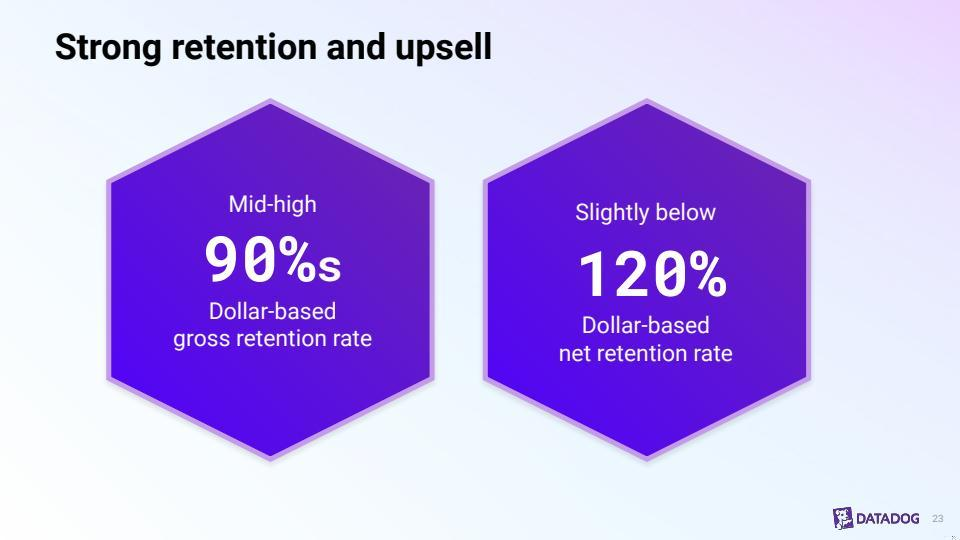

In [1]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "/Users/rlm/Desktop/Eval_Sets/multi_modal_presentations/DDOG/img_23.jpg"
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [3]:
from langchain.chat_models import ChatOllama
from langchain_core.messages import HumanMessage

chat_model = ChatOllama(
    model="bakllava",
)

# Call the chat model with both messages and images
content_parts = []
image_part = {
    "type": "image_url",
    "image_url": f"data:image/jpeg;base64,{image_b64}",
}
text_part = {"type": "text", "text": "What is the Daollar-based gross retention rate?"}

content_parts.append(image_part)
content_parts.append(text_part)
prompt = [HumanMessage(content=content_parts)]
chat_model(prompt)

AIMessage(content='90%')